In [10]:
import numpy as np
import random
import optuna
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score
import json
import os
from optuna.visualization import plot_optimization_history

In [11]:
SEED = 1234
 # Se puede cambiar a "precision" o "recall" o "f1-score"
SCORE = "f1-score"

In [12]:
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)

In [13]:
def get_trend_changes_report_dict(y_test: np.array, y_pred: np.array) -> float:
    """
    Calculate the trend changes score based on the test and predicted values.
    
    Args:
        y_test (np.array): True labels.
        y_pred (np.array): Predicted labels.
        
    Returns:
        float: The trend changes score.
    """
    y_df = pd.DataFrame([y_test, y_pred]).T
    y_df.columns = ["y_test", "y_pred"]
    y_df["y_test_shifted"] = y_df["y_test"].shift(-1)
    y_df["is_changed_trend_test"] = y_df["y_test"] != y_df["y_test_shifted"]
    y_df["y_predict_shifted"] = y_df["y_pred"].shift(-1)
    y_df["is_changed_trend_predict"] = y_df["y_pred"] != y_df["y_predict_shifted"]
    return classification_report(
        y_df["is_changed_trend_test"][:-1], 
        y_df["is_changed_trend_predict"][:-1], 
        digits=4,
        output_dict=True,
        zero_division=0
    )


def trend_changes_score(y_test: np.array, y_pred: np.array) -> float:
    """
    Calculate the trend changes score based on the test and predicted values.
    
    Args:
        y_test (np.array): True labels.
        y_pred (np.array): Predicted labels.
        
    Returns:
        float: The trend changes score.
    """
    y_df = pd.DataFrame([y_test, y_pred]).T
    y_df.columns = ["y_test", "y_pred"]
    y_df["y_test_shifted"] = y_df["y_test"].shift(-1)
    y_df["is_changed_trend_test"] = y_df["y_test"] != y_df["y_test_shifted"]
    y_df["y_predict_shifted"] = y_df["y_pred"].shift(-1)
    y_df["is_changed_trend_predict"] = y_df["y_pred"] != y_df["y_predict_shifted"]
    return classification_report(y_df["is_changed_trend_test"][:-1], y_df["is_changed_trend_predict"][:-1], digits=4)

def trend_changes_true(y_test: np.array, y_pred: np.array) -> float:
    """
    Calculate the trend changes score based on the test and predicted values.
    
    Args:
        y_test (np.array): True labels.
        y_pred (np.array): Predicted labels.
        
    Returns:
        float: The trend changes score.
    """
    y_df = pd.DataFrame([y_test, y_pred]).T
    y_df.columns = ["y_test", "y_pred"]
    y_df["y_test_shifted"] = y_df["y_test"].shift(-1)
    y_df["is_changed_trend_test"] = y_df["y_test"] != y_df["y_test_shifted"]
    y_df["y_predict_shifted"] = y_df["y_pred"].shift(-1)
    y_df["is_changed_trend_predict"] = y_df["y_pred"] != y_df["y_predict_shifted"]
    report = classification_report(
        y_df["is_changed_trend_test"][:-1],
        y_df["is_changed_trend_predict"][:-1],
        output_dict=True,
        zero_division=0
    )
    return report["True"][SCORE]

In [14]:
# Cargar datos
train = pd.read_csv("../../../data/post_cleaning/training_set.csv", parse_dates=["date"])
val = pd.read_csv("../../../data/post_cleaning/validation_set.csv", parse_dates=["date"])
test_set = pd.read_csv("../../../data/post_cleaning/test_set.csv", parse_dates=['date'])
X_train = train.drop(columns=["date", "target_trend"]).values
y_train = train["target_trend"].values
X_val = val.drop(columns=["date", "target_trend"]).values
y_val = val["target_trend"].values
X_test = test_set.drop(columns=['target_trend','date']).values
y_test = test_set['target_trend'].values

In [15]:
def objective(trial):
    set_seeds(SEED)  # Fijar semilla antes de cada trial
    n_estimators = trial.suggest_int("n_estimators", 50, 400)
    max_depth = trial.suggest_int("max_depth", 2, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=SEED
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    score = trend_changes_true(y_val, y_pred)
    return score

In [16]:
set_seeds(SEED)
study = optuna.create_study(
    direction="maximize", 
    sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(objective, n_trials=200)

[I 2025-08-24 15:33:30,050] A new study created in memory with name: no-name-64fd8521-0e62-4b84-a821-d6a1b956fe61
[I 2025-08-24 15:33:30,582] Trial 0 finished with value: 0.3050847457627119 and parameters: {'n_estimators': 117, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.3050847457627119.
[I 2025-08-24 15:33:31,131] Trial 1 finished with value: 0.14035087719298245 and parameters: {'n_estimators': 147, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 0 with value: 0.3050847457627119.
[I 2025-08-24 15:33:32,506] Trial 2 finished with value: 0.2807017543859649 and parameters: {'n_estimators': 289, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.3050847457627119.
[I 2025-08-24 15:33:31,197] Trial 3 finished with value: 0.2807017543859649 and parameters: {'n_estimators': 321, 'max_depth': 18, 

In [17]:
# Visualizar el historial de optimización
plot_optimization_history(study)

In [18]:
print("Mejores hiperparámetros encontrados:")
print(study.best_params)
print(f"Mejor score de {SCORE}: {study.best_value:.4f}")

Mejores hiperparámetros encontrados:
{'n_estimators': 313, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}
Mejor score de f1-score: 0.4068


GUARDAR EN JSON

In [19]:
# Guardar los mejores hiperparámetros y su valor
history = []
if os.path.exists("best_hyperparams.json"):
    try:
        with open("best_hyperparams.json", "r") as f:
            history = json.load(f)
    except (json.JSONDecodeError, ValueError):
        history = []

# Guardar ambos en un solo diccionario
history.append({
    "params": study.best_params,
    "value": study.best_value
})

with open("best_hyperparams.json", "w") as f:
    json.dump(history, f, indent=2)

CARGAR HIPERPARAMETROS DESDE JSON

In [11]:
# # Cargar historial de hiperparámetros y valores
# with open("best_hyperparams.json", "r") as f:
#     history = json.load(f)

# # Escoger el último (más reciente)
# best_params = history[-1]["params"]
# best_value = history[-1]["value"]

# # Si quieres ver todos:
# for i, entry in enumerate(history):
#     print(f"Hiperparámetros #{i+1}: {entry['params']}, Valor: {entry['value']}")

# # Si quieres escoger uno específico (por índice):
# # best_params = history[indice_que_quieras]["params"]
# # best_value = history[indice_que_quieras]["value"]

In [22]:
# Entrenar modelo final con los mejores hiperparámetros
set_seeds(SEED)
best_params = study.best_params
final_model = RandomForestClassifier(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"],
    max_features=best_params["max_features"],
    random_state=SEED
)
final_model.fit(X_train, y_train)
y_val_pred = final_model.predict(X_val)
print("RandomForest FINAL trend_changes_score:\n", trend_changes_score(y_val, y_val_pred))

RandomForest FINAL trend_changes_score:
               precision    recall  f1-score   support

       False     0.9179    0.9498    0.9336       259
        True     0.4800    0.3529    0.4068        34

    accuracy                         0.8805       293
   macro avg     0.6990    0.6514    0.6702       293
weighted avg     0.8671    0.8805    0.8725       293



In [23]:
# Reporte completo: precisión, recall y F1 por clase
report = classification_report(y_val, y_val_pred, digits=4)
print("LightGBM Report:\n", report)
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_val_pred))

LightGBM Report:
               precision    recall  f1-score   support

          -1     0.7480    0.9787    0.8479        94
           0     1.0000    0.0244    0.0476        41
           1     0.9118    0.9748    0.9422       159

    accuracy                         0.8435       294
   macro avg     0.8866    0.6593    0.6126       294
weighted avg     0.8717    0.8435    0.7873       294

Balanced accuracy: 0.6593188051511185


In [21]:
# Obtener predicciones
y_pred_test = final_model.predict(X_test)
print("Trend Change F1 Score:\n", trend_changes_score(y_test, y_pred_test))

Trend Change F1 Score:
               precision    recall  f1-score   support

       False     0.9061    0.9544    0.9296       263
        True     0.2941    0.1613    0.2083        31

    accuracy                         0.8707       294
   macro avg     0.6001    0.5578    0.5690       294
weighted avg     0.8416    0.8707    0.8536       294



In [14]:
y_pred_train = final_model.predict(X_train)
print("Random Forest Trend Changes Score:\n", trend_changes_score(y_train, y_pred_train))

Random Forest Trend Changes Score:
               precision    recall  f1-score   support

       False     0.9547    0.9688    0.9617      1219
        True     0.7206    0.6364    0.6759       154

    accuracy                         0.9315      1373
   macro avg     0.8377    0.8026    0.8188      1373
weighted avg     0.9285    0.9315    0.9297      1373



In [24]:
# --- Exportar y Comparar Métricas de Modelos (Validación) ---

# 1. Definir el nombre del modelo actual y el archivo de salida
model_name = 'Random Forest'
output_file = '../../../score_models/model_comparison_metrics.csv'

# 2. Calcular el reporte de clasificación estándar
# Usamos y_val_m y y_val_pred que están en la misma escala (0,1,2)
report_dict = classification_report(y_val, y_val_pred, output_dict=True, zero_division=0)
precision = report_dict['macro avg']['precision']
recall = report_dict['macro avg']['recall']
f1_score = report_dict['macro avg']['f1-score']


# 3. Calcular el reporte de cambio de tendencia
report = get_trend_changes_report_dict(y_val, y_val_pred)
trend_change_precision = report['True']['precision']
trend_change_recall = report['True']['recall']
trend_change_f1_score = report['True']['f1-score']

# 4. Organizar las nuevas métricas
new_metrics = {
    'precision': precision,
    'recall': recall,
    'f1_score': f1_score,
    'trend_change_precision': trend_change_precision,
    'trend_change_recall': trend_change_recall,
    'trend_change_f1_score': trend_change_f1_score
}

# 5. Cargar, actualizar y guardar el DataFrame de comparación
try:
    # Intentar cargar el archivo existente
    comparison_df = pd.read_csv(output_file, index_col='model')
    # Si existe, actualizar o añadir la fila para el modelo actual
    comparison_df.loc[model_name] = new_metrics
except FileNotFoundError:
    # Si no existe, crear un DataFrame nuevo directamente con los datos actuales
    comparison_df = pd.DataFrame([new_metrics], index=[model_name])

# Guardar el DataFrame actualizado en el CSV
comparison_df.to_csv(output_file, index_label='model')

In [16]:
import time

import numpy as np

start_time = time.time()
importances = final_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in final_model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.039 seconds


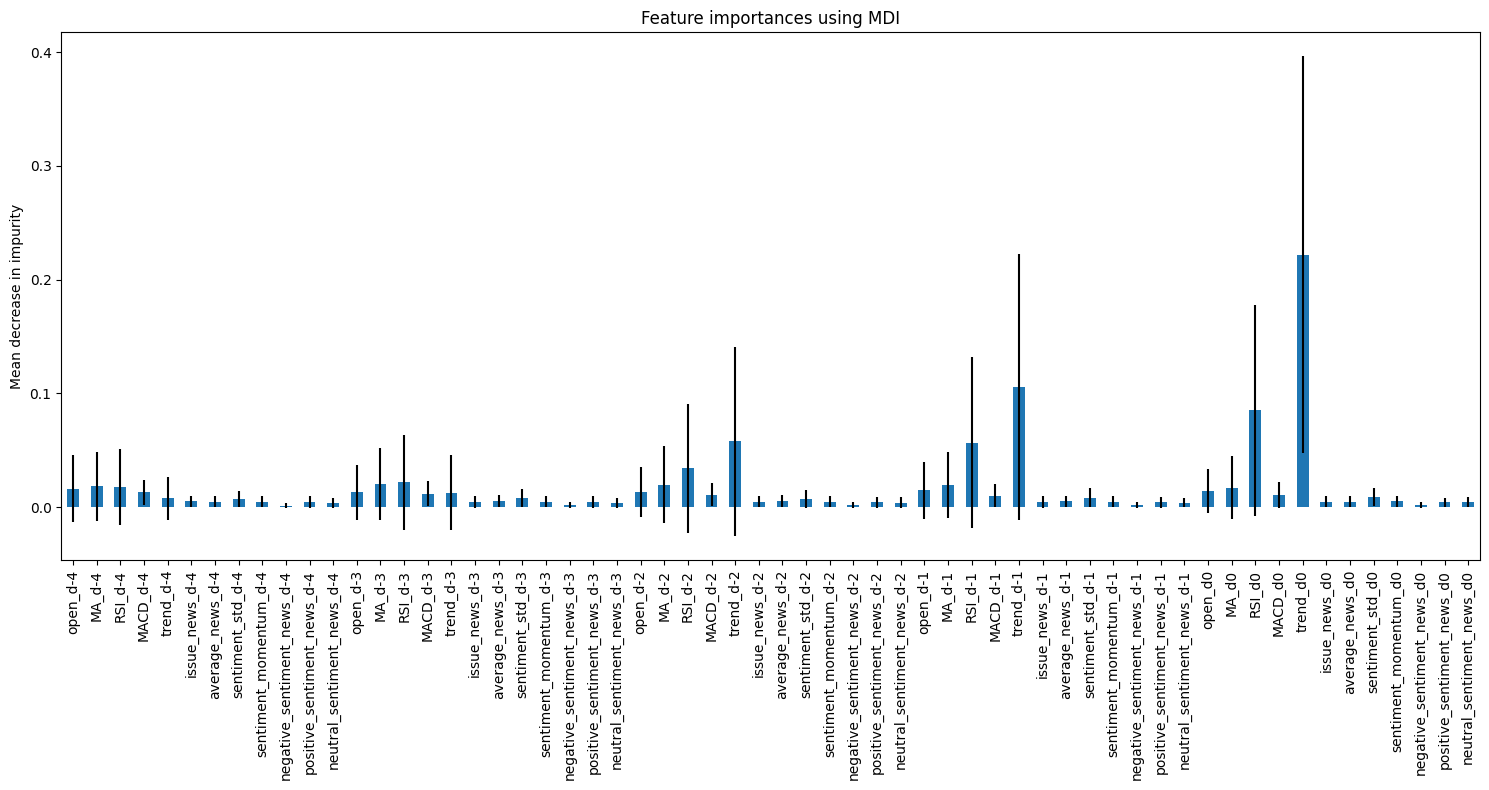

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

forest_importances = pd.Series(importances, index=train.drop(columns=["date", "target_trend"]).columns)

fig, ax = plt.subplots(figsize=(15, 8))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

--- Resultados del Backtesting ---
Capital Inicial: $10,000.00
Valor Final del Portafolio: $18,832.78
Retorno Total de la Estrategia: 88.33%
Retorno de Comprar y Mantener (Buy & Hold): 71.17%


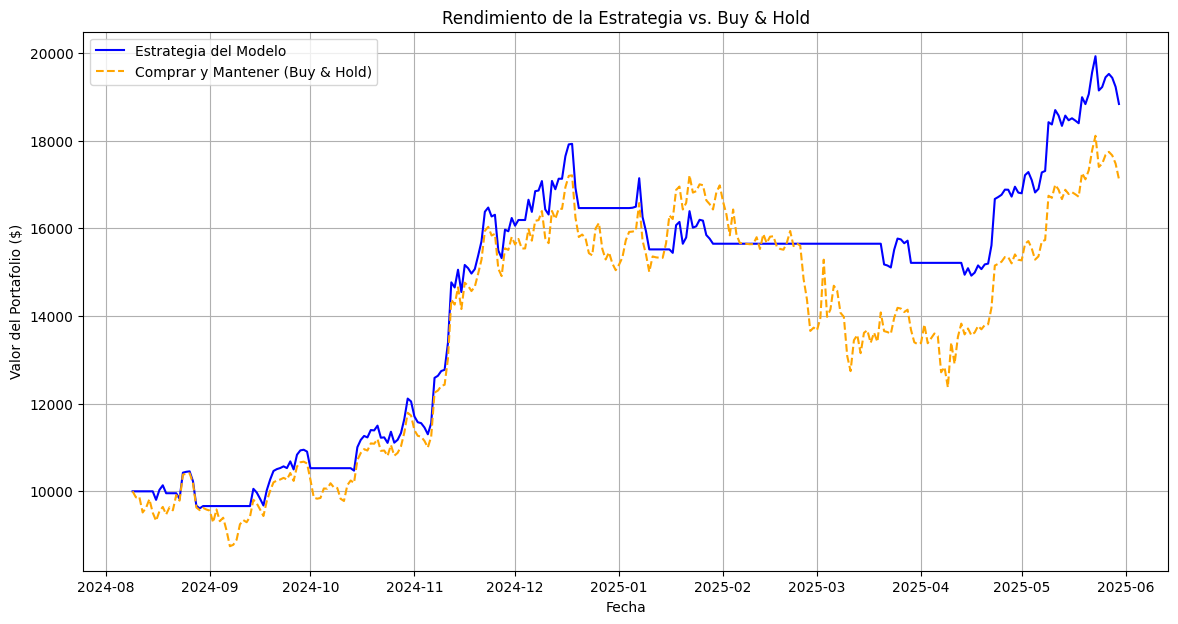

In [23]:
# --- Preparación de Datos para Backtesting ---

# 2. Crear un DataFrame para el backtest
# Usamos una copia del test_set original que contiene precios y fechas
backtest_df = test_set.copy()
backtest_df['signal'] = y_pred_test

# La columna de precio que usaremos es la del día más reciente en la ventana deslizante
# Basado en tu notebook dataCleaning.ipynb, esta columna debería existir. 
# Si el nombre es diferente, ajústalo aquí.
price_col = [col for col in test_set.columns if 'open_d0' in col][-1]


# --- Simulación de Backtesting ---

initial_capital = 10000.0
cash = initial_capital
position = 0.0  # Unidades de BTC
portfolio_values = []

for i, row in backtest_df.iterrows():
    price = row[price_col]
    signal = row['signal']
    
    # Lógica de trading
    if signal == 1 and cash > 0:  # Señal de compra
        position = cash / price
        cash = 0.0
    elif signal == -1 and position > 0:  # Señal de venta
        cash = position * price
        position = 0.0
    
    # Calcular el valor actual del portafolio
    current_portfolio_value = cash + position * price
    portfolio_values.append(current_portfolio_value)

backtest_df['portfolio_value'] = portfolio_values


# --- Cálculo de Métricas y Visualización ---

# 1. Calcular métricas de rendimiento
final_portfolio_value = backtest_df['portfolio_value'].iloc[-1]
total_return_pct = (final_portfolio_value - initial_capital) / initial_capital * 100
buy_and_hold_return_pct = (backtest_df[price_col].iloc[-1] - backtest_df[price_col].iloc[0]) / backtest_df[price_col].iloc[0] * 100

print("--- Resultados del Backtesting ---")
print(f"Capital Inicial: ${initial_capital:,.2f}")
print(f"Valor Final del Portafolio: ${final_portfolio_value:,.2f}")
print(f"Retorno Total de la Estrategia: {total_return_pct:.2f}%")
print(f"Retorno de Comprar y Mantener (Buy & Hold): {buy_and_hold_return_pct:.2f}%")

# 2. Visualizar los resultados
plt.figure(figsize=(14, 7))
plt.plot(backtest_df['date'], backtest_df['portfolio_value'], label='Estrategia del Modelo', color='blue')

# Normalizar el precio para comparar con "Buy & Hold"
buy_and_hold_values = (backtest_df[price_col] / backtest_df[price_col].iloc[0]) * initial_capital
plt.plot(backtest_df['date'], buy_and_hold_values, label='Comprar y Mantener (Buy & Hold)', color='orange', linestyle='--')

plt.title('Rendimiento de la Estrategia vs. Buy & Hold')
plt.xlabel('Fecha')
plt.ylabel('Valor del Portafolio ($)')
plt.legend()
plt.grid(True)
plt.show()